In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import tree
from IPython.display import Image

In [2]:
df = pd.read_csv('models/X.csv')
numeric_columns = ['min', 'max', 'mean', 'sd', 'range',
       'sum','duplicates', 'mra_D1_min', 'mra_D1_max', 'mra_D1_mean', 'mra_D1_sd',
       'mra_D1_range', 'mra_D1_zero', 'mra_D2_min', 'mra_D2_max',
       'mra_D2_mean', 'mra_D2_sd', 'mra_D2_range', 'mra_D2_zero', 'mra_D3_min',
       'mra_D3_max', 'mra_D3_mean', 'mra_D3_sd', 'mra_D3_range', 'mra_D3_zero',
       'tri_min', 'tri_max', 'tri_mean', 'tri_sd', 'tri_range', 'var_sill',
       'var_range', 'var_kappa']
# df = pd.concat([df[['image_id', 'classification']], pd.DataFrame(StandardScaler().fit_transform(df[numeric_columns]), columns=numeric_columns)])
df = pd.concat([
    df[['image_id', 'classification']],
    pd.DataFrame(StandardScaler().fit_transform(df[numeric_columns]), columns=numeric_columns)
], axis=1)
df

,image_id,classification,min,max,mean,sd,range,sum,duplicates,mra_D1_min,...,mra_D3_range,mra_D3_zero,tri_min,tri_max,tri_mean,tri_sd,tri_range,var_sill,var_range,var_kappa
0,1,high,-0.204857,-0.249751,-0.221113,-0.236633,-0.233770,-0.221113,1.325789,0.219985,...,-0.212168,-0.278706,-0.184219,-0.219473,-0.233930,-0.219448,-0.219465,-0.034204,-0.042722,-0.516985
1,2,high,-0.204857,-0.249751,-0.221113,-0.236633,-0.233770,-0.221113,1.325789,0.219985,...,-0.212168,-0.278706,-0.184219,-0.219473,-0.233930,-0.219448,-0.219465,-0.034204,-0.043209,-0.427503
2,3,high,-0.204857,-0.249751,-0.221113,-0.236633,-0.233770,-0.221113,1.325789,0.219985,...,-0.212168,-0.278706,-0.184219,-0.219473,-0.233930,-0.219448,-0.219465,-0.034204,-0.043363,-0.427503
3,4,high,-0.204857,-0.249751,-0.221113,-0.236633,-0.233770,-0.221113,1.325789,0.219985,...,-0.212168,-0.278706,-0.184219,-0.219473,-0.233930,-0.219448,-0.219465,-0.034204,-0.043552,-0.785430
4,5,high,-0.204857,-0.249751,-0.221113,-0.236633,-0.233770,-0.221113,1.325789,0.219985,...,-0.212168,-0.278706,-0.184219,-0.219472,-0.233930,-0.219448,-0.219465,-0.034204,-0.043558,-0.785430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,976,low,-0.190702,-0.234553,-0.206966,-0.223256,-0.222280,-0.206966,-0.782777,0.212401,...,-0.207097,-0.278706,-0.165564,-0.213116,-0.222878,-0.212169,-0.213111,-0.034204,-0.042569,0.109387
976,977,low,-0.190876,-0.234753,-0.206986,-0.223347,-0.222450,-0.206986,-0.782777,0.211591,...,-0.207254,-0.278706,-0.173680,-0.212918,-0.222725,-0.211847,-0.212911,-0.034204,-0.042511,0.019905
977,978,low,-0.190936,-0.234999,-0.207009,-0.223476,-0.222910,-0.207009,-0.782777,0.212053,...,-0.207320,-0.278706,-0.175988,-0.212907,-0.222838,-0.212015,-0.212900,-0.034204,-0.042581,0.019905
978,979,low,-0.190667,-0.234343,-0.206978,-0.223636,-0.221862,-0.206978,-0.782777,0.211638,...,-0.206971,-0.278706,-0.156765,-0.212517,-0.222714,-0.211992,-0.212513,-0.034204,-0.042475,0.019905


In [3]:
X = df.drop(['image_id','classification','min'],axis=1)
y = df['classification']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5)

# clf = LogisticRegression(random_state=0,max_iter=1000).fit(X_train, y_train)
clf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
# clf = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)estimator = model.estimators_[5]


print(f"Train Accuracy: {round(clf.score(X_train, y_train), 3)}")
print(f"Test Accuracy: {round(clf.score(X_test, y_test), 3)}")
print(confusion_matrix(y_test, clf.predict(X_test)))

print("\nFeature importances:")
zipped_lists = zip(clf.feature_importances_, X_train.columns)
sorted_pairs = sorted(zipped_lists, reverse=True)
for pair in sorted_pairs:
    print(f"{round(pair[0], 2)} {pair[1]}")

Train Accuracy: 1.0
Test Accuracy: 0.973
[[250   0   4]
 [  0  80   1]
 [  8   0 147]]

Feature importances:
0.23 var_range
0.08 mean
0.08 sum
0.06 var_kappa
0.05 max
0.03 sd
0.03 mra_D2_sd
0.03 tri_range
0.03 mra_D2_max
0.02 mra_D1_sd
0.02 range
0.02 mra_D2_range
0.02 tri_mean
0.02 mra_D3_min
0.02 mra_D3_sd
0.02 tri_min
0.02 mra_D3_range
0.02 mra_D1_min
0.02 tri_sd
0.02 tri_max
0.02 mra_D2_min
0.02 mra_D1_max
0.02 mra_D1_range
0.02 mra_D3_max
0.01 mra_D1_zero
0.01 mra_D2_zero
0.01 mra_D3_zero
0.01 mra_D2_mean
0.01 mra_D1_mean
0.01 var_sill
0.01 mra_D3_mean
0.0 duplicates


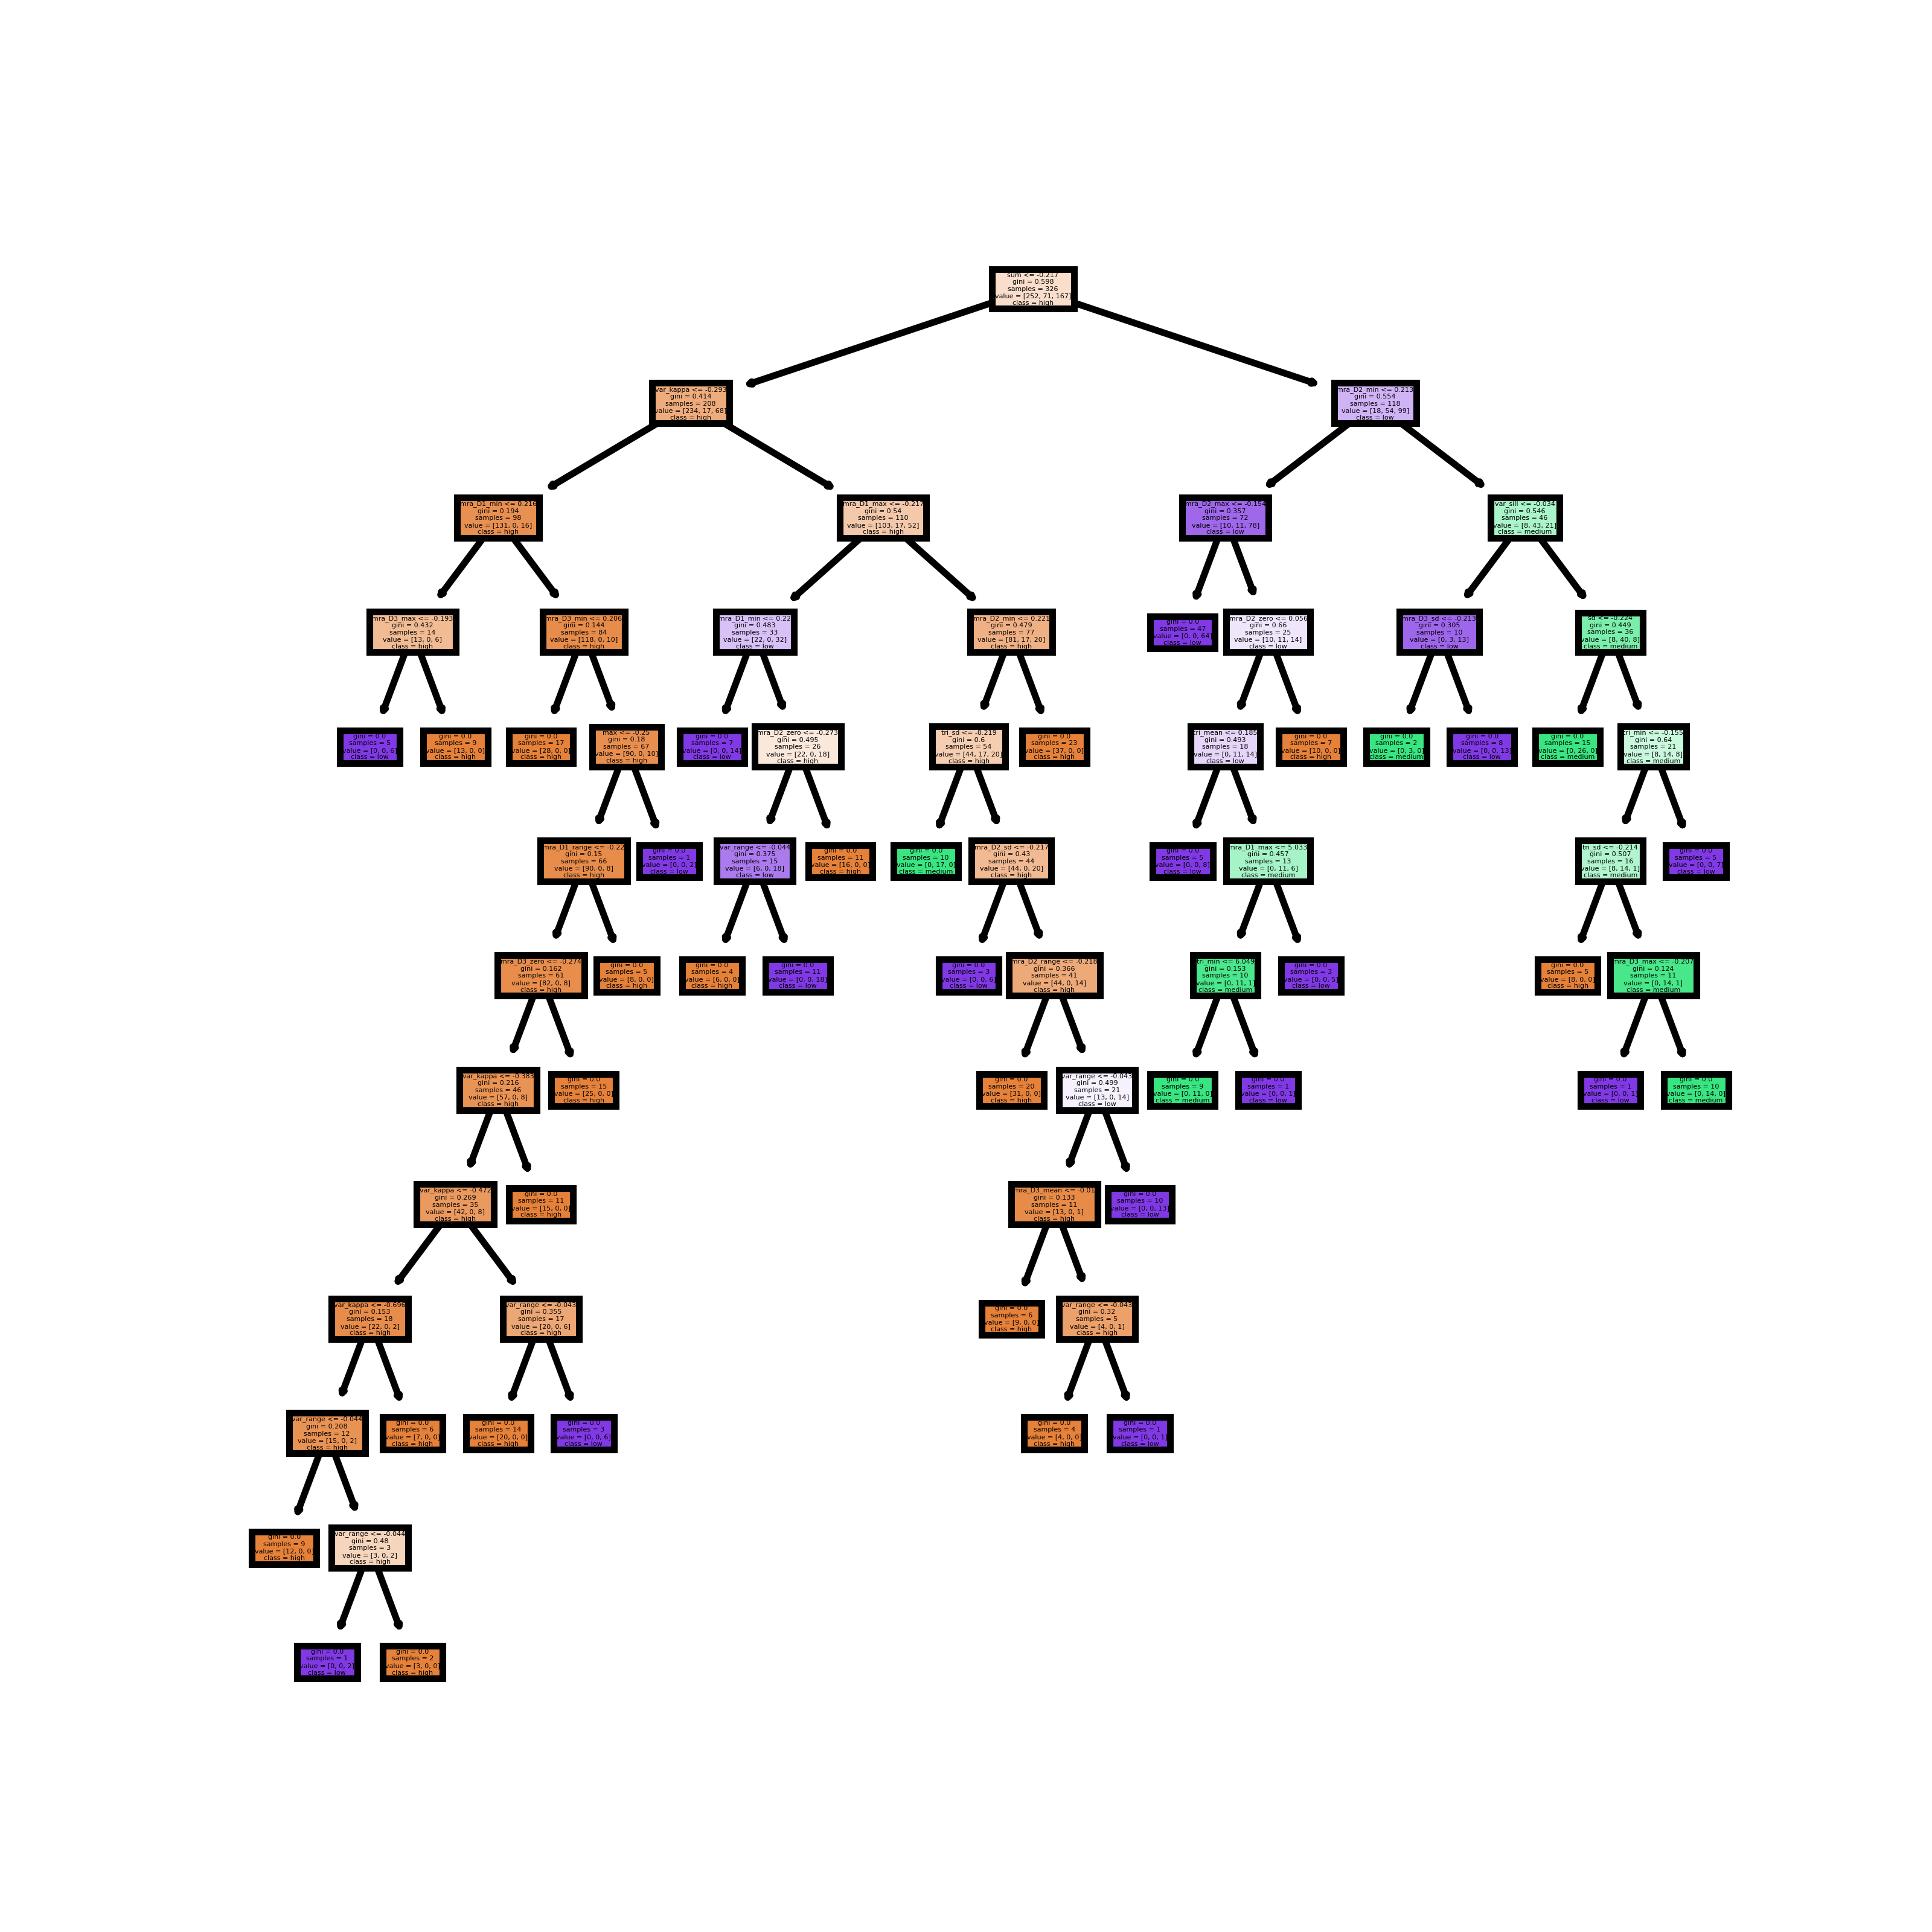

In [4]:
fn=X_train.columns
cn=['high','medium','low']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(clf.estimators_[0],
               feature_names = fn, 
               class_names=cn,
               filled = True);
fig.savefig('rf_individualtree.png')


Image(filename = 'rf_individualtree.png')
